### Scattering of a plane wave by a homogeneous sphere

This demo illustrates how to:

 * Compute the scattering of a plane wave by a homogeneous dielectric obstable
 * Solve the volume integral equation using an iterative method
 * Postprocess the solution to evaluate the total field
 * Check the accuracy by comparing to the analytical solution
 * Make a nice plot of the solution in the domain

In [1]:
import os
import sys
# FIXME: figure out how to avoid this sys.path stuff
sys.path.append(os.path.join(os.path.abspath(''), '../../'))
import numpy as np
from vines.geometry.geometry import shape
from vines.fields.plane_wave import PlaneWave
from vines.operators.acoustic_operators import volume_potential
from vines.precondition.threeD import circulant_embed_fftw
from vines.operators.acoustic_matvecs import mvp_vec_fftw, mvp_domain, mvp_potential_x_perm
from scipy.sparse.linalg import LinearOperator, gmres, bicgstab
from analytical.mie_series_function import mie_function, mie_function_density_contrast
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D 
from plotting import set_axes_equal
import time

In [2]:
'''                         Define parameters                               '''
# We consider a sphere of radius 1mm and refractive index 1.2
# The incident field is a plane wave of wavelength 0.5mm and unit amplitude
# travelling in the positive x-direction
# * Sphere info
geom = 'sphere'
radius = 2.5e-3
refInd = 1.2 + 1j * 0.0
# * Wavelength
lambda_ext = 1.5e-3
# * Plane wave info
Ao = 1
direction = np.array((1, 0, 0))
ko = 2 * np.pi / lambda_ext  # exterior wavenumber

print('Size parameter = ', ko * radius)

Size parameter =  10.471975511965978


In [3]:
# Define the resolution of the voxel mesh - this is given in terms of number
# of voxels per wavelength. 10 voxels per wavelength typically gives a
# reasonable (<5%) accuracy. See demo_convergence.py for an example script in
# which the convergence of the scheme is considered w.r.t. mesh resolution
nPerLam = 10

# Get mesh geometry and interior wavelength
r, idx, res, P, lambda_int = shape(geom, refInd, lambda_ext, radius,
                                   nPerLam, 1)

(L, M, N) = r.shape[0:3]  # number of voxels in x-, y-, z-directions

# Plot geometry

(L, M, N, _) = r.shape  # number of voxels in x-, y-, z-directions
#  Arrays containing the x, y, z coordinates, these are handy for plotting the geometry
xd = r[:, :, :, 0]
yd = r[:, :, :, 1]
zd = r[:, :, :, 2]

In [4]:
# Get plane wave incident field
Uinc = PlaneWave(Ao, ko, direction, r)

In [5]:
# Voxel permittivities
Mr = np.zeros((L, M, N), dtype=np.complex128)
Mr[idx] = refInd**2 - 1

In [6]:
# Assemble volume potential operator
toep = volume_potential(ko, r)
toep = ko**2 * toep

In [7]:
# Circulant embedding of volume potential operator
circ_op = circulant_embed_fftw(toep, L, M, N)

In [8]:
# Create array that has the incident field values in sphere, and zero outside sphere
xIn = np.zeros((L, M, N), dtype=np.complex128)
xIn[idx] = Uinc[idx]
# Reshape into vector for linear system
xInVec = xIn.reshape((L*M*N, 1), order='F')

In [9]:
# Set up matvec and linear operator
mvp = lambda x: mvp_vec_fftw(x, circ_op, idx, Mr)

A = LinearOperator((L*M*N, L*M*N), matvec=mvp)

In [10]:
# Iterative solve with GMRES or BiCG-Stab (or iterative solver of your choice)
def residual_vector(rk):
    'Function to store residual vector in iterative solve'
    global resvec
    resvec.append(rk)

start = time.time()
resvec = []
# sol, info = gmres(A, xInVec, tol=1e-5, callback=residual_vector)
sol, info = bicgstab(A, xInVec, tol=1e-5, callback=residual_vector)
print("The linear system was solved in {0} iterations".format(len(resvec)))
end = time.time()
print('Solve time = ', end-start, 's')

The linear system was solved in 16 iterations
Solve time =  1.3554699420928955 s


In [11]:
# Compute scattered and hence total field
idx_n = np.ones((L, M, N), dtype=bool)
Usca = mvp_potential_x_perm(sol, circ_op, idx_n, Mr).reshape(L, M, N, order='F')
U = Uinc + Usca

In [12]:
# Get the analytical solution on central slice for comparison
P = mie_function_density_contrast(ko * radius, refInd, L, 1, 1)
U_centre = U[:, :, np.int(np.round(N/2))]
error = np.linalg.norm(U_centre-np.conj(P)) / np.linalg.norm(P)
print('Error = ', error)

Error =  0.02152479482369237


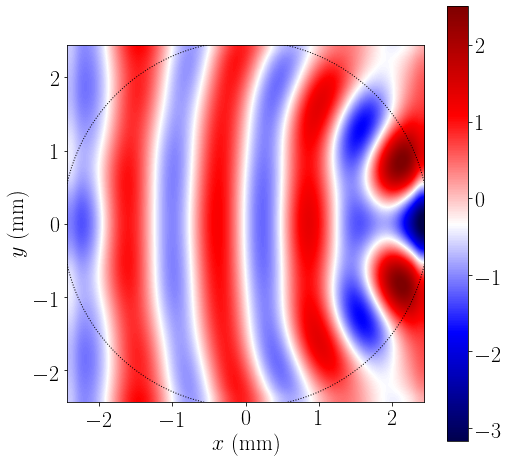

In [13]:
# Create pretty plot of field over central slice of the sphere
matplotlib.rcParams.update({'font.size': 22})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
# Domain extremes
xmin, xmax = r[0, 0, 0, 0], r[-1, 0, 0, 0]
ymin, ymax = r[0, 0, 0, 1], r[0, -1, 0, 1]
plt.imshow(np.real(U_centre.T),
           extent=[xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16')
plt.xlabel(r'$x$ (mm)')
plt.ylabel(r'$y$ (mm)')
circle = plt.Circle((0., 0.), radius*1e3, color='black', fill=False,
                    linestyle=':')
ax.add_artist(circle)
plt.colorbar()
# fig.savefig('results/sphere.pdf')
# plt.close()